In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [6]:
data = input_data.read_data_sets('data',one_hot=True)


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [0]:
# Reshape training and testing image
x_train = data.train.images
x_test = data.test.images
y_train = data.train.labels
y_test = data.test.labels

In [8]:
x_train.shape, y_train.shape

((55000, 784), (55000, 10))

In [9]:
x_test.shape, y_test.shape

((10000, 784), (10000, 10))

In [0]:
x_train = x_train.reshape(-1,28,28,1)

In [0]:
x_test = x_test.reshape(-1,28,28,1)

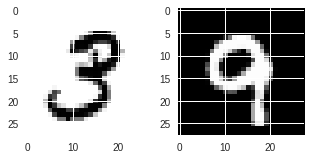

In [12]:

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train[1], (28,28))
plt.imshow(curr_img)


# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test[99,:], (28,28))
plt.imshow(curr_img, cmap='gray')


In [0]:
x = tf.placeholder('float',[None,28,28,1])
y = tf.placeholder('float',[None,10])

In [0]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [0]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,10), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

In [0]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [17]:
pred = conv_net(x,weights,biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [0]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
# Initializing the variables
init = tf.global_variables_initializer()

In [0]:
batch_size  = 32
saver = tf.train.Saver()

In [38]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('output', sess.graph)
    for i in range(12):
        for batch in range(len(x_train)//32):
            batch_x = x_train[batch*batch_size:min((batch+1)*batch_size,len(x_train))]
            batch_y = y_train[batch*batch_size:min((batch+1)*batch_size,len(y_train))]    
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: x_test,y : y_test})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    save_path = saver.save(sess, "output/model.ckpt")
    print("Model saved in path: %s" % save_path)
    
    summary_writer.close()

Iter 0, Loss= 0.017087, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.97340
Iter 1, Loss= 0.011164, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98180
Iter 2, Loss= 0.000320, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98920
Iter 3, Loss= 0.000382, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98990
Iter 4, Loss= 0.000078, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99060
Iter 5, Loss= 0.000029, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99080
Iter 6, Loss= 0.000037, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99000
Iter 7, Loss= 0.000020, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99340
Iter 8, Loss= 0.000018, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99320
Iter 9, Loss= 0.000005, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99220


In [47]:
import os
print( os.getcwd() )
print( os.listdir('output') )

/content
['events.out.tfevents.1533504634.db9fbe01aecb', 'events.out.tfevents.1533503776.db9fbe01aecb', 'events.out.tfevents.1533504288.db9fbe01aecb', 'events.out.tfevents.1533503965.db9fbe01aecb', 'checkpoint', 'events.out.tfevents.1533504496.db9fbe01aecb', 'model.ckpt.index', 'events.out.tfevents.1533504318.db9fbe01aecb', 'events.out.tfevents.1533502949.db9fbe01aecb', 'model.ckpt.meta', 'events.out.tfevents.1533504338.db9fbe01aecb', 'model.ckpt.data-00000-of-00001']


In [0]:
from google.colab import files
files.download( "output/model.ckpt.meta" ) 

In [0]:
model_json = model.to_json()
with open("drive/app/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("drive/app/model_weights.h5")
print("Saved model to drive")

In [0]:
saver = tf.train.Saver()
save_path = saver.save(sess, "outpu/model.ckpt")
print("Model saved in path: %s" % save_path)
saver.save(sess, 'my-model')